In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
import jax
jax.config.update('jax_enable_x64',True)
import triangle
import matplotlib.pyplot as plt
from lm import LM
import scipy as sp
jnp.set_printoptions(precision=4,linewidth=120)


In [3]:
Nside=16
Nsquare=Nside*4
v=np.linspace(0,1,Nside,endpoint=False)
z=np.zeros(Nside)
o=np.ones(Nside)
square=np.c_[np.r_[v,o,1-v,z],np.r_[z,v,o,1-v]]
square_seg = np.c_[np.arange(square.shape[0]-1),np.arange(1,square.shape[0])]
square_seg = np.r_[square_seg,np.array([[square.shape[0]-1,0]])]

Ncircle = 32
r=0.2
cx,cy=0.35,0.5
theta = np.linspace(0, 2 * np.pi, Ncircle, endpoint=False)
circle = np.stack([r*np.cos(theta)+cx, r*np.sin(theta)+cy], axis=1)
circle_seg = np.c_[np.arange(circle.shape[0]-1), np.arange(1,circle.shape[0])]
circle_seg = np.r_[circle_seg,np.array([[circle.shape[0]-1,0]])]
circle_seg+=square.shape[0]

In [4]:
A = dict(vertices=np.r_[square,circle], segments=np.r_[square_seg,circle_seg], holes=[[cx, cy]])
B = triangle.triangulate(A, 'qpa0.0004D')

In [5]:
tr=B['triangles']
verts = B['vertices']
vertx,verty = verts.T
Nv = vertx.size
topidx = np.where(verty==0)[0]
botidx = np.where(verty==1)[0]
leftidx = np.where((vertx==0)*(verty>0)*(verty<1))[0]
rightidx = np.where((vertx==1)*(verty>0)*(verty<1))[0]
circleidx = np.where((vertx-cx)**2 + (verty-cy)**2 < r**2 + 1e-10)[0]

squareidx = np.r_[topidx, botidx, leftidx, rightidx]

u=np.zeros(Nv)
v=np.zeros(Nv)
p=np.zeros(Nv)

angle = np.arctan2(verty[circleidx]-cy,vertx[circleidx]-cx)
vertx[circleidx],verty[circleidx]=r*np.cos(angle)+cx, r*np.sin(angle)+cy

top_normals = np.tile(np.array([0., -1.]), (topidx.size,1))
bot_normals = np.tile(np.array([0., 1.]), (botidx.size,1))
left_normals = np.tile(np.array([1., 0.]), (leftidx.size,1))
right_normals = np.tile(np.array([-1., 0.]), (rightidx.size,1))

square_normals = np.r_[top_normals, bot_normals, left_normals, right_normals]
circle_normals = np.c_[np.cos(angle), np.sin(angle)]

w=1.
u[circleidx]=-r*w*np.sin(angle)
v[circleidx]=r*w*np.cos(angle)


interior = np.setdiff1d(np.arange(Nv), np.r_[squareidx, circleidx])
Ninterior=interior.size
boundary = np.r_[squareidx, circleidx]


u=jnp.asarray(u)
v=jnp.asarray(v)


In [6]:
def get_neighbors(i):
    return np.setdiff1d(np.unique(np.ravel(tr[np.where(tr==i)[0]])),i)

def get_five_neighbors(i):
    nb=get_neighbors(i)
    boundary_nb = np.intersect1d(nb, boundary)
    non_boundary_nb = np.setdiff1d(nb, boundary)
    if boundary_nb.size > 2:  # allow only 2 boundary neighbors
        d=np.sum((verts[i]-verts[boundary_nb])**2,axis=1)
        boundary_nb_idx = np.argsort(d)
        if np.in1d(i, boundary):  # if boundary element, take 2 closes boundary neighbors
            boundary_nb=boundary_nb_idx[:2]
        else: #if interior element, take 2 furthest boundary neighbors
            boundary_nb=boundary_nb_idx[-2:]
        nb = np.union1d(boundary_nb, non_boundary_nb)
    if nb.size<5:  # less than 5, consider non_boundary neighbors of non-boundary neighbors
        nb2=nb.copy()
        for ii in nb2:
            nb=np.union1d(nb, np.setdiff1d(get_neighbors(ii), boundary))
        nb=np.setdiff1d(nb,i)
    if nb.size<5:  # if still less than 5, repeat again.
        nb2=nb.copy()
        for ii in nb2:
            nb=np.union1d(nb, np.setdiff1d(get_neighbors(ii), boundary))
        nb=np.setdiff1d(nb,i)
        
    if nb.size>5:
        d=np.sum((verts[i]-verts[nb])**2,axis=1)
        return nb[np.argpartition(d,5)[:5]]
    else:  #nb == 5
        return nb

# f = a0*x^2 + a1*y^2 + a2*x + a3*y + a4*xy + f0
# df/dx = 2a0*x + a2 + a4*y
# df/dy = 2a1*y + a3 + a4*x
# df2/dx2 = 2a0
# df2/dy2 = 2a1
# df2/dxdy = a4

def get_LU(i):
    n5 = get_five_neighbors(i)
    if n5.size < 5:
        print(i)
        print(n5)
    x,y = (verts[n5]-verts[i]).T
    return jax.scipy.linalg.lu_factor(np.c_[x**2, y**2, x, y, x*y]),n5

def get_LUs(idxs):
    LUs=[]
    pivs=[]
    n5s=[]
    for i in idxs:
        (LU, piv), n5 = get_LU(i)
        LUs.append(LU)
        pivs.append(piv)
        n5s.append(n5)
    n5s=np.stack(n5s)
    LUs=np.stack(LUs)
    pivs=np.stack(pivs)
    return LUs, pivs, n5s

all_verts = np.arange(Nv)
LUs, pivs, n5s=get_LUs(all_verts)
lu_solve_vec=jax.vmap(jax.scipy.linalg.lu_solve,in_axes=((0,0),0))

@jax.jit
def get_coeffs(f):
    return lu_solve_vec((LUs, pivs), jnp.take(f,n5s)-f[:,None])


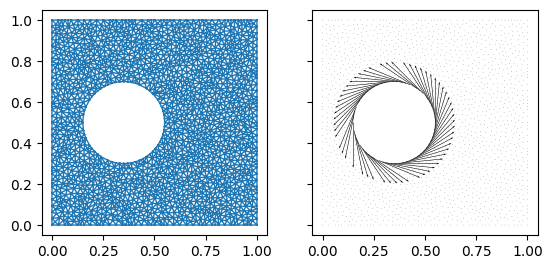

In [7]:


fig1, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].set_aspect('equal')
_=ax[0].triplot(verts[:,0],verts[:,1],'-',triangles=tr,lw=1)
ax[1].set_aspect('equal')
_=ax[1].quiver(verts[:,0],verts[:,1], u, v, scale=1)

In [8]:

#Stokes flow
@jax.jit
def eqs(x, u=u, v=v):
    
    u=u.at[interior].set(x[:Ninterior])
    v=v.at[interior].set(x[Ninterior:2*Ninterior])
    ua=get_coeffs(u)
    va=get_coeffs(v)
    
    ueqs= (2*ua[interior,0] + 2*ua[interior,1])
    veqs= (2*va[interior,0] + 2*va[interior,1])
    return jnp.r_[ueqs, veqs]

xguess=np.r_[u[interior], v[interior]]
solver=LM(eqs, xguess)
res = solver(L=1000, rho_tol = 0.1, maxiter=100, xtol=1e-15, ftol=1e-15,iter_print=25)

usol=u.at[interior].set(res.x[:Ninterior])
vsol=v.at[interior].set(res.x[Ninterior:2*Ninterior])
ua=get_coeffs(usol)
va=get_coeffs(vsol)
print(np.max(np.abs(ua[interior,2] + va[interior,3])))

Levenberg-Marquadrt Jacobian shape: (3168, 3168)
Iteration: 25  L: 1.26e-01
f abs mean: 1.40e-14  max: 1.44e-12
Iteration: 30  L: 2.05e+02
f abs mean: 1.39e-14  max: 1.20e-12
1.0136337189043096


In [9]:
rho=1000.

#pressure
@jax.jit
def eqs(p, ua=ua, va=va):

    pa=get_coeffs(p)
    peqs_interior = 2*(pa[interior,0]+pa[interior,1]) + rho*(ua[interior,2]**2 + 2*ua[interior,3]*va[interior,2] + va[interior,3]**2)
    peqs_square = jnp.sum(pa[squareidx,2:4]*square_normals,axis=1)
    peqs_circle = jnp.sum(pa[circleidx,2:4]*circle_normals,axis=1) 
    return jnp.r_[peqs_interior, peqs_square, peqs_circle]

solver=LM(eqs, p)
res = solver(L=1, rho_tol = 0.1, maxiter=1000, xtol=1e-12, ftol=1e-15,iter_print=25)
psol=res.x

Levenberg-Marquadrt Jacobian shape: (1806, 1806)
Iteration: 25  L: 1.00e-12
f abs mean: 4.21e-02  max: 3.68e+01
Iteration: 50  L: 1.00e-12
f abs mean: 4.07e-02  max: 3.68e+01
Iteration: 75  L: 1.00e-12
f abs mean: 4.07e-02  max: 3.68e+01
Iteration: 87  L: 3.17e-02
f abs mean: 4.07e-02  max: 3.68e+01


In [44]:
rho=1000.
nu = 2e-3
@jax.jit
def eqs(x, u=u, v=v):
    
    u=u.at[interior].set(x[:Ninterior])
    v=v.at[interior].set(x[Ninterior:2*Ninterior])
    p=x[2*Ninterior:]
    ua=get_coeffs(u)
    va=get_coeffs(v)
    pa=get_coeffs(p)
    
    ueqs= u[interior]*ua[interior,2] + v[interior]*ua[interior,3] + pa[interior,2]/rho - nu*(2*ua[interior,0] + 2*ua[interior,1])
    veqs= u[interior]*va[interior,2] + v[interior]*va[interior,3] + pa[interior,3]/rho - nu*(2*va[interior,0] + 2*va[interior,1])
    peqs_interior = 2*(pa[interior,0]+pa[interior,1]) + rho*(ua[interior,2]**2 + 2*ua[interior,3]*va[interior,2] + va[interior,3]**2)
    peqs_square = jnp.sum(pa[squareidx,2:4]*square_normals,axis=1)
    peqs_circle = jnp.sum(pa[circleidx,2:4]*circle_normals,axis=1) 
    return jnp.r_[ueqs, veqs, peqs_interior, peqs_square, peqs_circle]
    
xguess=np.r_[usol[interior], vsol[interior], psol]
solver=LM(eqs, xguess)
res = solver(xguess, L=1, rho_tol = 0.1, maxiter=200, xtol=1e-5, ftol=1e-15,iter_print=25)

usol=u.at[interior].set(res.x[:Ninterior])
vsol=v.at[interior].set(res.x[Ninterior:2*Ninterior])
psol=res.x[2*Ninterior:]
ua=get_coeffs(usol)
va=get_coeffs(vsol)
print(np.mean(np.abs(ua[interior,2] + va[interior,3])),np.max(np.abs(ua[interior,2] + va[interior,3])))

Levenberg-Marquadrt Jacobian shape: (4974, 4974)
Iteration: 25  L: 1.26e-04
f abs mean: 7.44e-02  max: 3.32e+00
Iteration: 50  L: 1.56e-04
f abs mean: 7.42e-02  max: 3.31e+00
Iteration: 75  L: 1.92e-04
f abs mean: 7.41e-02  max: 3.31e+00
Iteration: 100  L: 2.37e-04
f abs mean: 7.39e-02  max: 3.31e+00
Iteration: 125  L: 2.96e-06
f abs mean: 7.40e-02  max: 3.30e+00
Iteration: 150  L: 3.65e-06
f abs mean: 7.37e-02  max: 3.30e+00
Iteration: 175  L: 4.51e-06
f abs mean: 7.35e-02  max: 3.29e+00
0.12706428333446035 1.989662327158951


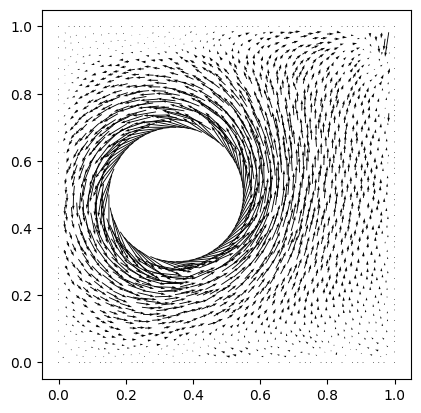

In [45]:

fig1, ax = plt.subplots(1,1, sharex=True, sharey=True)
ax.set_aspect('equal')
_=ax.quiver(verts[:,0],verts[:,1], usol, vsol, scale=2)

In [11]:
jnp.partition(psol,10)[:10]

Array([-0.0168, -0.0151, -0.0148, -0.0125, -0.0101, -0.0099, -0.0095, -0.0095, -0.0091, -0.0079], dtype=float64)